In [47]:
import pandas as pd
import seaborn as sns
from scipy import stats

## data prep
from sklearn.model_selection import train_test_split
import missingno as msno 

## modeling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

## evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## visualization 
from plotnine import *
from plotly.offline import iplot
import plotly_express as px


## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [195]:
df = pd.read_csv('../washington-post-election-night-model/data/county_data.csv')

In [196]:
## change fips to string
df['fips'] = df['fips'].astype(str)
df['fips'] = df['fips'].str.zfill(5)

In [197]:
## features we will mainly use
features = [
    #'fips',
    'female',
    'male',
    'white',
    'black',
    'aapi',
    'hispanic',
    'other_race_alone',
    'median_income',
    'bachelor_or_higher',
    'age_le_30',
    'age_ge_30_le_45',
    'age_ge_45_le_65',
    'age_ge_65',
    'total_votes_2016'
]

# Target variable

In [198]:
df['vote_change']=(df['total_votes_2020']-df['total_votes_2016'])

# Data Prep

##### Explore which counties are blank

In [199]:
df = df.dropna()

##### Train test split

In [200]:
X = df[features]
y = df['total_votes_2020']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

# Functions

In [70]:
def calculate_error(df):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    df['absolute_error_lower'] = (df['lower'] - df['total_votes_2020']).abs()
    df['absolute_error_upper'] = (df['upper'] - df['total_votes_2020']).abs()
    
    df['absolute_error_interval'] = (df['absolute_error_lower'] + df['absolute_error_upper']) / 2
    df['absolute_error_mid'] = (df['mid'] - df['total_votes_2020']).abs()
    
    df['in_bounds'] = df['total_votes_2020'].between(left=df['lower'], right=df['upper'])
    
    
    df['percent_error_lower'] = (df['absolute_error_lower']/df['total_votes_2020'])*100
    df['percent_error_upper'] = (df['absolute_error_upper']/df['total_votes_2020'])*100
    df['percent_error_interval'] = (df['absolute_error_interval']/df['total_votes_2020'])*100
    df['percent_error_mid'] = (df['absolute_error_mid']/df['total_votes_2020'])*100

    
    return df

In [71]:
def plot_interval_metrics(df):
    percent_in_bounds = df['in_bounds'].mean() * 100
    metrics_to_plot = df[[col for col in df if 'percent_error' in col]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

    p = (ggplot(dat,aes(x="metric",y="Percent Error")) +
      geom_jitter(width = .25,alpha=.4,show_legend=False, color = "#a54f7e") +
      scale_y_log10() +
      labs(title=f"Error Metrics     In Bounds = {percent_in_bounds:.2f}%", x = "Interval Metric"))
    
    return p

In [72]:
def plot_interval_trends(df):
    p = (ggplot(df, aes(x = "total_votes_2016", y="total_votes_2020")) +
     geom_point(size=1,alpha=.1,show_legend=False) + 
     #geom_line(aes(x = "total_votes_2020", y="upper"), size=.5,alpha=1,show_legend=False) +
     #geom_line(aes(x = "total_votes_2020", y="lower"), size=.5,alpha=1,show_legend=False) +
     geom_ribbon(aes(x="total_votes_2016", ymax="upper", ymin="lower"), fill="#a54f7e", alpha=.75) +
     scale_y_log10() +
     scale_x_log10() +
     xlim(1000, 25000) +
     ylim(1000, 25000) +
     labs(x = "Total Votes in 2016",y="Total Votes in 2020",color="",title="Prediction Interval")
    )
    return p


##### Evaluate how close the guesses are 

Text(0.5, 1.0, 'OLS with Prediction Interval for 2020 Election')

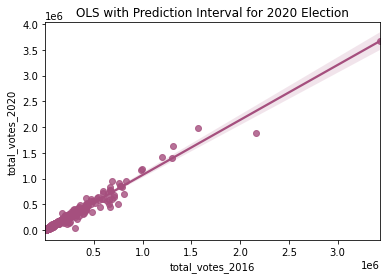

In [11]:

sns.regplot(x='total_votes_2016', y='total_votes_2020', data=df, color = "#a54f7e").set_title('OLS with Prediction Interval for 2020 Election')
#plt.xlim(10000, 20000)
#plt.ylim(10000, 20000)
#fig.suptitle('Figure 4: Age Groups vs. Voting in 2020', fontsize=12, y=1.01)


In [12]:
reg = LinearRegression()
reg.fit(Xtrain, ytrain)

LinearRegression()

# Parametric, OLS

##### Generating prediction intervals and then counting counties in interval vs. out of interval.

We can calculate the percentage of the time the actual value is within the range, but this can be easily optimized by making the interval very wide. Therefore, we also want a metric that takes into account how far away the predictions are from the actual value, such as absolute error.


In the notebook, I’ve provided a function that calculates the absolute error for the lower, mid, and upper predictions and then averages the upper and lower error for an “Interval” absolute error. We can do this for each data point and then plot a boxplot of the errors (the percent in bounds is in the title):

https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

In [13]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

N_ESTIMATORS = 100
MAX_DEPTH = 5

# Each model has to be separate
lower_model = GradientBoostingRegressor(
    loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)
# The mid model will use the default
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(
    loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)

In [14]:
# modeling 
lower_model.fit(Xtrain, ytrain)
mid_model.fit(Xtrain, ytrain)
upper_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.95, loss='quantile', max_depth=5)

In [15]:
## get predictions 
predictions = pd.DataFrame(ytest)
predictions['total_votes_2016'] = df['total_votes_2016']
predictions['lower'] = lower_model.predict(Xtest)
predictions['mid'] = mid_model.predict(Xtest)
predictions['upper'] = upper_model.predict(Xtest)
predictions.describe()

,total_votes_2020,total_votes_2016,lower,mid,upper
count,6.230000e+02,6.230000e+02,623.000000,623.000000,6.230000e+02
mean,5.520503e+04,5.076323e+04,27304.633620,48899.272622,6.386591e+04
std,1.764292e+05,1.632440e+05,52470.449905,120200.207083,1.646036e+05
min,3.110000e+02,2.830000e+02,313.754925,825.802918,4.447031e+02
25%,4.872500e+03,4.509000e+03,4242.993796,5009.682066,7.708105e+03
50%,1.190500e+04,1.060400e+04,10045.292507,11691.833664,1.776214e+04
75%,3.197150e+04,2.874150e+04,25350.737918,31703.922890,4.597811e+04
max,1.991563e+06,2.158615e+06,632802.139146,944799.346322,1.792881e+06


In [16]:
predictions = calculate_error(predictions)

C:\Users\madel\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



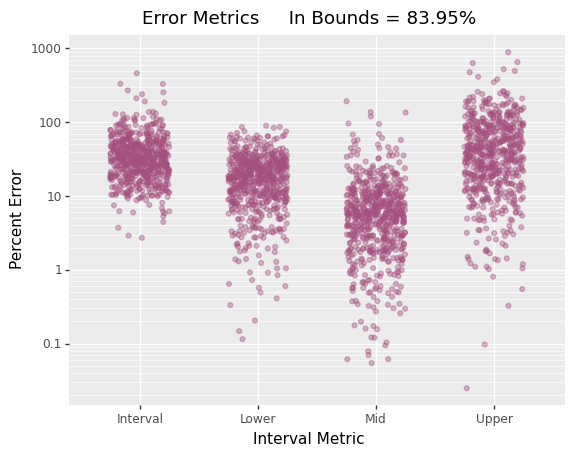

<ggplot: (127958998553)>

In [17]:
plot_interval_metrics(predictions)

C:\Users\madel\anaconda3\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning:

Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.


C:\Users\madel\anaconda3\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning:

Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.


C:\Users\madel\anaconda3\lib\site-packages\plotnine\layer.py:464: PlotnineWarning:

geom_point : Removed 206 rows containing missing values.



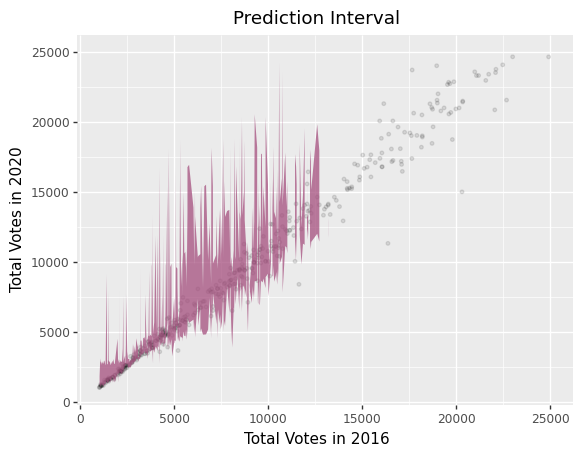

<ggplot: (127958971778)>

In [18]:
plot_interval_trends(predictions)

# Non-parametric, KNN

In [19]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(Xtrain, ytrain)

KNeighborsRegressor(n_neighbors=1)

In [20]:
# split the data into a train and validation sets 

# base_model can be any regression 
#modelbase_mode.fit(X1, y1) 
base_prediction = knn.predict(Xtest) 

#compute the RMSE value 
## scikit RSME
error = mean_squared_error(base_prediction, ytest) ** 0.5 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest) 
st_dev = error

In [21]:
error_model = LinearRegression()

https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

In [22]:
# split the data in train a validation set
#X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5)

# base_model can be any regression model 
knn.fit(Xtrain, ytrain) 
base_prediction = knn.predict(Xtest) 

# compute the prediction error vector on the validation set 
validation_error = (base_prediction - ytest) ** 2 
error_model.fit(Xtest, validation_error) 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest)
error = error_model.predict(Xtest)

## what is the downside of comparing MSE for all models?
## entire analysis has an argument
## systematic relationship in residuals
this is a model that makes certain kinds of mistakes for certains kinds of counties 
what is a way of examining a distribution of errors of knn that makes sense to me
KNN furthest outside mean error going to look at those observations
these counties that are really poorly classified, going to take the top 10 highest error counties >. demographicaly similaries 
knn > kmeans (clustering
             random centroid and nearest points and you repeat that processs until minimized distance)
parametric analysis of errors on non paramatirc does not work
flexible model and applied inflexible way of examining error distribution
knn has different has no pbjective function

In [23]:
knnPredictions = pd.DataFrame(ytest)
knnPredictions['total_votes_2016'] = df['total_votes_2016']
knnPredictions['std'] = error
knnPredictions['std'] = knnPredictions['std'].abs()**0.5

In [24]:
from scipy.stats import t


## sample size
N = len(knnPredictions)

## degrees of freedom
df = 2*N - 2

t = t.ppf(0.95, df)

In [25]:
knnPredictions['mid'] = knn.predict(Xtest)
knnPredictions['lower'] = knnPredictions['mid'] - (knnPredictions['std']*t)
knnPredictions['upper'] = knnPredictions['mid'] + (knnPredictions['std']*t)

#assert (predictions['upper'] > predictions['lower']).all()

knnPredictions.tail()

,total_votes_2020,total_votes_2016,std,mid,lower,upper
2569,16819.0,16051.0,27697.099269,16348.0,-29243.625655,61939.625655
2399,930.0,861.0,82054.541325,754.0,-134314.293434,135822.293434
2468,36795.0,33085.0,112469.440573,41560.0,-143573.633755,226693.633755
1301,17675.0,15456.0,67473.180076,14313.0,-96753.214475,125379.214475
2911,1165.0,1091.0,25440.309506,1982.0,-39894.770425,43858.770425


In [26]:
knnPredictions = calculate_error(knnPredictions)

C:\Users\madel\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



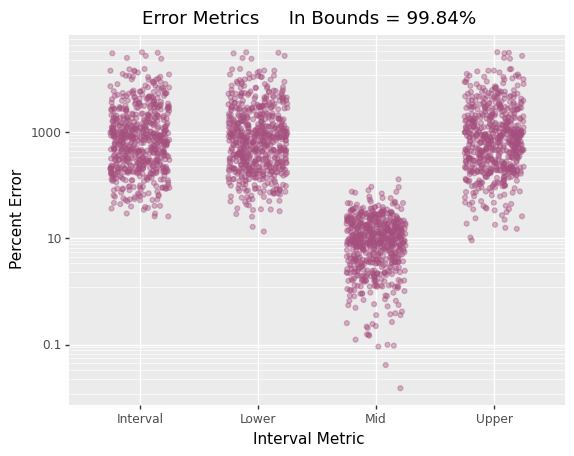

<ggplot: (127951354164)>

In [27]:
plot_interval_metrics(knnPredictions)

C:\Users\madel\anaconda3\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning:

Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.


C:\Users\madel\anaconda3\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning:

Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.


C:\Users\madel\anaconda3\lib\site-packages\plotnine\layer.py:464: PlotnineWarning:

geom_point : Removed 206 rows containing missing values.



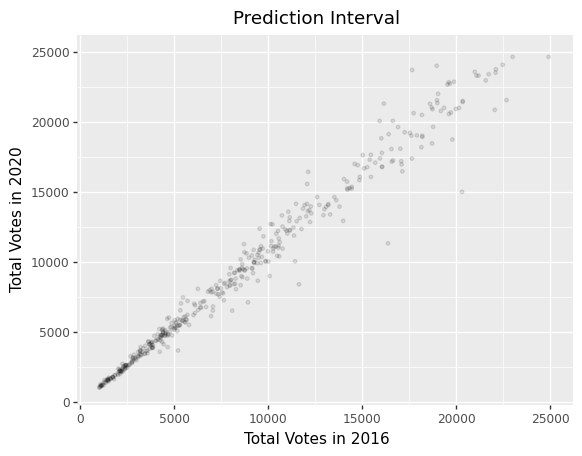

<ggplot: (127953745321)>

In [28]:
plot_interval_trends(knnPredictions)

# Quantile Regression Visually

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [6]:
mod = smf.quantreg('total_votes_2020 ~ total_votes_2016 + \
    female + \
    male + \
    white + \
    black + \
    aapi + \
    hispanic + \
    other_race_alone + \
    median_income + \
    bachelor_or_higher + \
    age_le_30 + \
    age_ge_30_le_45 + \
    age_ge_45_le_65 + \
    age_ge_65', df)

In [10]:
models

,q,a,b,lb,ub
0,0.05,0.000401,1.230939,1.226059,1.235820
1,0.15,-74.607997,1.158127,1.154565,1.161688
2,0.25,-66.721483,1.118444,1.115214,1.121675
3,0.35,-0.000019,1.085011,1.082127,1.087895
4,0.45,-0.000026,1.059224,1.056246,1.062203
5,0.55,-33.580142,1.029857,1.026581,1.033133
6,0.65,0.000018,0.966950,0.963371,0.970528
7,0.75,-0.000015,0.913636,0.909428,0.917843
8,0.85,0.000114,0.815140,0.809841,0.820438
9,0.95,0.000026,0.717944,0.709218,0.726670


In [7]:
quantiles = np.arange(.05, .96, .1)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['total_votes_2016']] + res.conf_int().loc['total_votes_2016'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('total_votes_2020 ~ total_votes_2016', df).fit()
ols_ci = ols.conf_int().loc['total_votes_2016'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['total_votes_2016'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.

C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.

C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.

C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.

C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.

C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.

C:\Users\madel\a

      q          a         b        lb        ub
0  0.05   0.000401  1.230939  1.226059  1.235820
1  0.15 -74.607997  1.158127  1.154565  1.161688
2  0.25 -66.721483  1.118444  1.115214  1.121675
3  0.35  -0.000019  1.085011  1.082127  1.087895
4  0.45  -0.000026  1.059224  1.056246  1.062203
5  0.55 -33.580142  1.029857  1.026581  1.033133
6  0.65   0.000018  0.966950  0.963371  0.970528
7  0.75  -0.000015  0.913636  0.909428  0.917843
8  0.85   0.000114  0.815140  0.809841  0.820438
9  0.95   0.000026  0.717944  0.709218  0.726670
{'a': 991.8360231686947, 'b': 1.0695422301134125, 'lb': 1.063851125365848, 'ub': 1.075233334860977}


C:\Users\madel\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:190: IterationLimitWarning:

Maximum number of iterations (1000) reached.



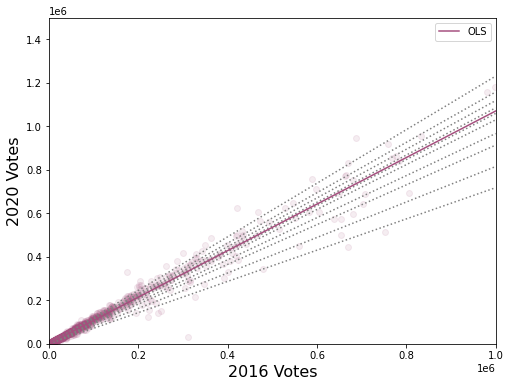

In [8]:
x = np.arange(df.total_votes_2016.min(), df.total_votes_2016.max(), 50)

get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='#a54f7e', label='OLS')
ax.scatter(df.total_votes_2016, df.total_votes_2020, alpha=.1, color = '#a54f7e')
ax.set_xlim((0, 1000000))
ax.set_ylim((0, 1500000))
legend = ax.legend()
ax.set_xlabel('2016 Votes', fontsize=16)
ax.set_ylabel('2020 Votes', fontsize=16);

# plot intervals 

In [ ]:
# how many different types of county errors do we get?

# k means to label point into a cluster

# run classifer model and get feature importance !!

In [ ]:
## visualizations
# https://www.r-bloggers.com/2019/07/measuring-feature-importance-in-k-means-clustering-and-variants-thereof/

## k means parameter tuning
# https://realpython.com/k-means-clustering-python/

In [202]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

#boston = load_boston()
#X, y = boston.data, boston.target
kf = KFold(n_splits=5, random_state=0)

rfqr = RandomForestQuantileRegressor(
    random_state=0, min_samples_split=10, n_estimators=1000)

In [203]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

In [204]:
y_true_all = []
lower = []
upper = []

for train_index, test_index in kf.split(X):
    #X_train, X_test, y_train, y_test = (
    #X[train_index], X[test_index], y[train_index], y[test_index])

    rfqr.set_params(max_features=X_train.shape[1] // 3)
    rfqr.fit(Xtrain, ytrain)
    
    y_true_all = np.concatenate((y_true_all, ytest))
    upper = np.concatenate((upper, rfqr.predict(Xtest, quantile=95)))
    lower = np.concatenate((lower, rfqr.predict(Xtest, quantile=5)))



# Center such that the mean of the prediction interval is at 0.0
#y_true_all -= mean
#upper -= mean
#lower -= mean

In [210]:
interval = upper - lower
sort_ind = np.argsort(interval)
y_true_all = y_true_all[sort_ind]

upper = upper[sort_ind]
lower = lower[sort_ind]
mean = (upper + lower) / 2

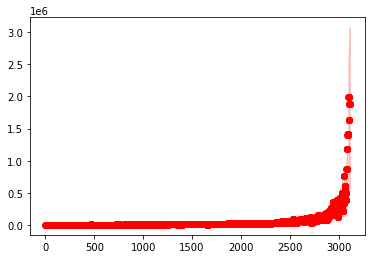

In [211]:
## ordered by interval

plt.plot(y_true_all, "ro")

plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")


#plt.xlabel("Ordered samples.")
#plt.ylabel("Values and prediction intervals.")
#plt.lim([0, 500])
plt.show()

# K means clustering

In [218]:
from sklearn.cluster import KMeans
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_)
print(kmeans.predict([[0, 0], [12, 3]]))
print(kmeans.cluster_centers_)

[1 1 1 0 0 0]
[1 0]
[[10.  2.]
 [ 1.  2.]]


In [ ]:
## get mean or median residuals by model
## get interval between 95 and 5, percentage of population rather than just straight number

## value = residuals, value = interval

## K means cluster on value

## determine ideal number of clusters

## label clusters

## classify clusters

## model importance

In [221]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xtrain, ytrain)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

# random forest quantile regression 

In [ ]:
rfqr = RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=1000)

In [68]:
## get predictions 
rfqrPredictions = pd.DataFrame(ytest)
rfqrPredictions['total_votes_2016'] = df['total_votes_2016']
rfqrPredictions['lower'] = rfqr.predict(Xtest, quantile=5)
rfqrPredictions['mid'] = rfqr.predict(Xtest, quantile = 50)
rfqrPredictions['upper'] = rfqr.predict(Xtest, quantile=95)
rfqrPredictions.tail()

,total_votes_2020,total_votes_2016,lower,mid,upper
2569,16819.0,16051.0,14638.953040,16974.443678,19783.010738
2399,930.0,861.0,652.690530,852.203068,975.478009
2468,36795.0,33085.0,27594.319987,39109.359825,48775.061323
1301,17675.0,15456.0,14449.160258,16712.512765,19473.327329
2911,1165.0,1091.0,993.096015,1327.721923,1606.822342


In [74]:
rfqrPredictions = calculate_error(rfqrPredictions)

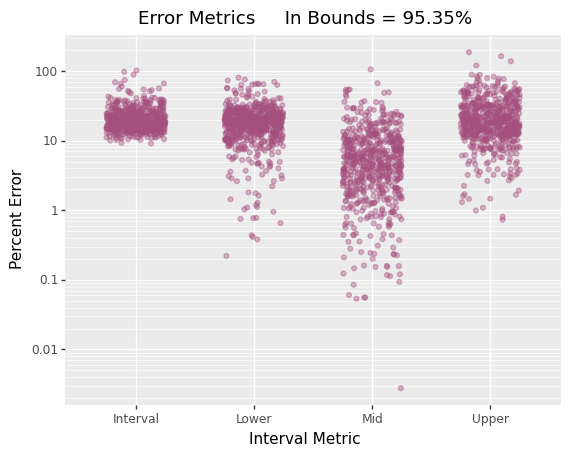

<ggplot: (99615503165)>

In [75]:
plot_interval_metrics(rfqrPredictions)

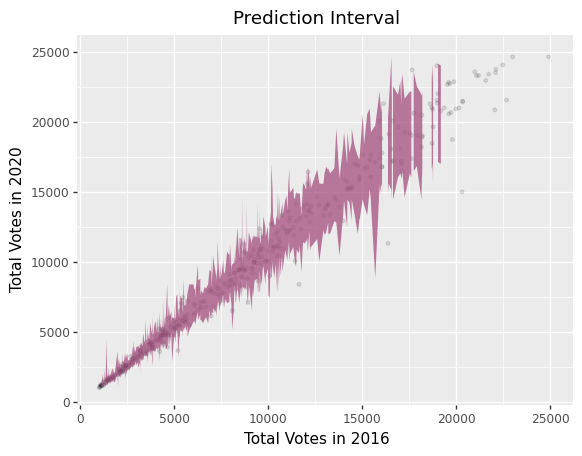

<ggplot: (99615518224)>

In [76]:
plot_interval_trends(rfqrPredictions)

# Conformalized quantile regression

In [ ]:
# Conformal Wrapper 
#https://github.com/donlnz/nonconformist/blob/master/examples/icp_regression_tree.py

In [93]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston

from nonconformist.base import RegressorAdapter
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc, RegressorNormalizer


# example

In [170]:
data = load_boston()

In [172]:
idx = np.random.permutation(data.target.size)
train = idx[:int(idx.size / 3)]
calibrate = idx[int(idx.size / 3):int(2 * idx.size / 3)]
test = idx[int(2 * idx.size / 3):]

In [173]:
underlying_model = RegressorAdapter(DecisionTreeRegressor(min_samples_leaf=5))
nc = RegressorNc(underlying_model, AbsErrorErrFunc())
icp = IcpRegressor(nc)
icp.fit(data.data[train, :], data.target[train])
icp.calibrate(data.data[calibrate, :], data.target[calibrate])

In [191]:
data.data[calibrate, :]

array([[6.96215e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.94430e+02, 1.71100e+01],
       [3.23700e-02, 0.00000e+00, 2.18000e+00, ..., 1.87000e+01,
        3.94630e+02, 2.94000e+00],
       [2.73100e-02, 0.00000e+00, 7.07000e+00, ..., 1.78000e+01,
        3.96900e+02, 9.14000e+00],
       ...,
       [1.30580e-01, 0.00000e+00, 1.00100e+01, ..., 1.78000e+01,
        3.38630e+02, 1.53700e+01],
       [7.97800e-02, 4.00000e+01, 6.41000e+00, ..., 1.76000e+01,
        3.96900e+02, 7.19000e+00],
       [6.11540e-01, 2.00000e+01, 3.97000e+00, ..., 1.30000e+01,
        3.89700e+02, 5.12000e+00]])

In [192]:
Xtrain

array([[  6610.,   6806.,  12779., ...,   4475.,   3365.,   7577.],
       [  1995.,   5318.,   5095., ...,   1895.,   1603.,   2401.],
       [ 17880.,  17809.,  30697., ...,   9388.,   7332.,  12970.],
       ...,
       [ 13913.,  13825.,  16882., ...,   7790.,   5712.,  10751.],
       [ 70704.,  68224., 125510., ...,  34366.,  17941.,  57730.],
       [521541., 505666., 781004., ..., 243394., 197361., 421640.]])

In [174]:
prediction = icp.predict(data.data[test, :], significance=0.1)
header = ['min','max','truth','size']
size = prediction[:, 1] - prediction[:, 0]
table = np.vstack([prediction.T, data.target[test], size.T]).T
df = pd.DataFrame(table, columns=header)
print(df)

           min        max  truth  size
0    16.264286  31.764286   22.3  15.5
1    13.100000  28.600000   17.8  15.5
2    12.990000  28.490000   21.0  15.5
3    31.590000  47.090000   23.6  15.5
4    10.364286  25.864286   19.4  15.5
..         ...        ...    ...   ...
164   5.466667  20.966667   19.4  15.5
165  17.738889  33.238889   26.6  15.5
166  22.425000  37.925000   48.3  15.5
167  11.930000  27.430000   25.0  15.5
168  11.390000  26.890000   19.8  15.5

[169 rows x 4 columns]


In [175]:
prediction.shape

(169, 2)

In [176]:
data.data[test, :].shape

(169, 13)

In [180]:
Xtest.shape

(1002, 14)

In [ ]:


underlying_model = RegressorAdapter(DecisionTreeRegressor(min_samples_leaf=5))
normalizing_model = RegressorAdapter(KNeighborsRegressor(n_neighbors=1))
normalizer = RegressorNormalizer(underlying_model, normalizing_model, AbsErrorErrFunc())
nc = RegressorNc(underlying_model, AbsErrorErrFunc(), normalizer)
icp = IcpRegressor(nc)
icp.fit(data.data[train, :], data.target[train])
icp.calibrate(data.data[calibrate, :], data.target[calibrate])

prediction = icp.predict(data.data[test, :], significance=0.1)
header = ['min','max','truth','size']
size = prediction[:, 1] - prediction[:, 0]
table = np.vstack([prediction.T, data.target[test], size.T]).T
df = pd.DataFrame(table, columns=header)
print(df)

# my version

In [114]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

3111

In [181]:
# -----------------------------------------------------------------------------
# Setup training, calibration and test indices
# -----------------------------------------------------------------------------
## create a random order of index
idx = np.random.permutation(y.size)


## get a random third of data for training
idx_train = idx[:int(idx.size / 3)]

## get a random third of the data for calibration
idx_calibrate = idx[int(idx.size / 3):int(2 * idx.size / 3)]

## get a random third of the data for testing 
idx_test = idx[int(2 * idx.size / 3):]

In [182]:
Xtrain = X.reindex(index = idx_train).dropna().to_numpy()
ytrain = y.reindex(index = idx_train).dropna().to_numpy()

Xcal = X.reindex(index = idx_cal).dropna().to_numpy()
ycal = y.reindex(index = idx_cal).dropna().to_numpy()

Xtest = X.reindex(index = idx_test).dropna().to_numpy()
ytest = y.reindex(index = idx_test).dropna().to_numpy()

In [183]:
# -----------------------------------------------------------------------------
# Without normalization
# -----------------------------------------------------------------------------
# Train and calibrate
# -----------------------------------------------------------------------------
underlying_model = RegressorAdapter(DecisionTreeRegressor(min_samples_leaf=5))
## RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=1000)




## Nonconformity scorer using an underlying regression model
nc = RegressorNc(underlying_model, AbsErrorErrFunc())

## Nonconformity scorer object used to calculate nonconformity of calibration examples and test patterns
## Inductive conformal classifier
icp = IcpRegressor(nc)
icp.fit(Xtrain, ytrain)


icp.calibrate(Xcal, ycal)

In [184]:
# -----------------------------------------------------------------------------
# Predict
# -----------------------------------------------------------------------------
prediction = icp.predict(Xtest)
header = ['min','max','truth','size']

#cqr = pd.DataFrame(np.vstack(prediction), columns = header)




#size = prediction[:, 1] - prediction[:, 0]

#table = np.vstack([prediction, ytest, size]).T
#df = pd.DataFrame(table, columns=header)
#print(df)

In [185]:
prediction.shape

(1003, 2, 99)

In [186]:
Xtest.shape

(1003, 14)

In [143]:
data = load_boston()
idx = np.random.permutation(data.target.size)
train = idx[:int(idx.size / 3)]
calibrate = idx[int(idx.size / 3):int(2 * idx.size / 3)]
test = idx[int(2 * idx.size / 3):]

In [139]:
prediction.T

array([[[ -23132.        , -151168.91111111,  240966.77142857, ...,
         -137063.37142857, -143381.55      , -127866.3       ],
        [ 280995.6       ,  152958.68888889,  545094.37142857, ...,
          167064.22857143,  160746.05      ,  176261.3       ]],

       [[  67997.37142857,  -60039.53968254,  332096.14285714, ...,
          -45934.        ,  -52252.17857143,  -36736.92857143],
        [ 189866.22857143,   61829.31746032,  453965.        , ...,
           75934.85714286,   69616.67857143,   85131.92857143]],

       [[  93725.46666667,  -34311.44444444,  357824.23809524, ...,
          -20205.9047619 ,  -26524.08333333,  -11008.83333333],
        [ 164138.13333333,   36101.22222222,  428236.9047619 , ...,
           50206.76190476,   43888.58333333,   59403.83333333]],

       ...,

       [[ 128914.        ,     877.08888889,  393012.77142857, ...,
           14982.62857143,    8664.45      ,   24179.7       ],
        [ 128949.6       ,     912.68888889,  393048.3714

In [97]:
# -----------------------------------------------------------------------------
# With normalization
# -----------------------------------------------------------------------------
# Train and calibrate
# -----------------------------------------------------------------------------
underlying_model = RegressorAdapter(DecisionTreeRegressor(min_samples_leaf=5))
normalizing_model = RegressorAdapter(KNeighborsRegressor(n_neighbors=1))
normalizer = RegressorNormalizer(underlying_model, normalizing_model, AbsErrorErrFunc())


nc = RegressorNc(underlying_model, AbsErrorErrFunc(), normalizer)
icp = IcpRegressor(nc)
icp.fit(data.data[train, :], data.target[train])
icp.calibrate(data.data[calibrate, :], data.target[calibrate])

In [98]:
# -----------------------------------------------------------------------------
# Predict
# -----------------------------------------------------------------------------
prediction = icp.predict(data.data[test, :], significance=0.1)
header = ['min','max','truth','size']
size = prediction[:, 1] - prediction[:, 0]
table = np.vstack([prediction.T, data.target[test], size.T]).T
df = pd.DataFrame(table, columns=header)
print(df)

            min         max  truth        size
0    -22.511623   90.951623   31.0  113.463245
1      8.583673   34.571882   21.0   25.988209
2      7.360818   47.172515   27.5   39.811697
3    -66.658595  105.858595   17.5  172.517189
4    -60.471095  112.046095   18.4  172.517189
..          ...         ...    ...         ...
164  -46.615224  106.659669   30.8  153.274893
165   19.173519   29.126481   24.1    9.952962
166   -4.215824   52.515824   23.1   56.731648
167 -121.589160  155.433604   17.2  277.022764
168   11.945741   21.898703   23.1    9.952962

[169 rows x 4 columns]


https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3

https://github.com/yromano/cqr/blob/master/cqr_synthetic_data_example_1.ipynb

https://github.com/yromano/cqr/blob/master/cqr_synthetic_data_example_2.ipynb

# graveyard

##### Functions

In [77]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')


split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'

%matplotlib inline
np.random.seed(1)

# desired miscoverage error
alpha = 0.1
# low and high target quantiles
quantiles = [5, 95]

# maximal number of testpoints to plot
max_show = 1000

# save figures?
save_figures = False

# parameters of random forests
n_estimators = 100
min_samples_leaf = 25
max_features = 1# 1D signal
random_state = 0

In [78]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

##### linear quantile regression

##### quantile random forrest regression

In [79]:
# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.95
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = random_state
params_qforest["range_vals"] = 2
params_qforest["num_vals"] = 25


# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)



##### conformal stuff

In [80]:
# number of training examples
n_train = len(Xtrain)

In [81]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

In [82]:
Xtrain_idx_train = Xtrain.reindex(index = idx_train).dropna().to_numpy()
ytrain_idx_train = ytrain.reindex(index = idx_train).dropna().to_numpy()

Xtrain_idx_cal = Xtrain.reindex(index = idx_cal).dropna().to_numpy()
ytrain_idx_cal = ytrain.reindex(index = idx_cal).dropna().to_numpy()

In [83]:
# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 

nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(Xtrain_idx_train, ytrain_idx_train)

# compute the absolute errors on calibration data
icp.calibrate(Xtrain_idx_cal, ytrain_idx_cal)

In [84]:
Xtestnp =Xtest.to_numpy()

# produce predictions for the test set, with confidence equal to significance
cqrPredictions = icp.predict(Xtestnp, significance=alpha)


In [85]:
cqrPredictions

array([[  4449.81586291,  11450.25277423],
       [  5572.35629081,  13968.7538498 ],
       [ 84322.07812438, 597114.11583292],
       ...,
       [ 23811.75018968,  77018.94887158],
       [ 11498.81725599,  24110.26481787],
       [  2124.61605663,   7247.16495072]])

In [86]:
#y_lower = predictions[:,0]
#y_upper = predictions[:,1]

# compute the low and high conditional quantile estimation
pred = quantile_estimator.predict(Xtest)

In [87]:
#cqrPredictions = pd.DataFrame(cqrPredictions, columns = ['lower', 'upper'])
cqrPredictions = pd.DataFrame(pred, columns = ['lower', 'upper'])

##### evaluation

In [88]:
cqrPredictions['mid'] = (cqrPredictions['upper'] + cqrPredictions['lower'])/2

cqrPredictions['total_votes_2020'] = df['total_votes_2020']
cqrPredictions['total_votes_2016'] = df['total_votes_2016']


In [89]:
cqrPredictions = calculate_error(cqrPredictions)

In [90]:
cqrPredictions

,lower,upper,mid,total_votes_2020,total_votes_2016,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid,in_bounds,percent_error_lower,percent_error_upper,percent_error_interval,percent_error_mid
0,3287.972736,12612.095901,7950.034319,10033.0,9585.0,6745.027264,2579.095901,4662.061582,2082.965681,True,67.228419,25.706129,46.467274,20.761145
1,4410.513164,15130.596976,9770.555070,13117.0,12401.0,8706.486836,2013.596976,5360.041906,3346.444930,True,66.375595,15.351048,40.863322,25.512274
2,83160.234998,598275.958959,340718.096979,11079.0,11384.0,72081.234998,587196.958959,329639.096979,329639.096979,False,650.611382,5300.089890,2975.350636,2975.350636
3,1123.605462,4852.945646,2988.275554,254827.0,303520.0,253703.394538,249974.054354,251838.724446,251838.724446,False,99.559071,98.095592,98.827332,98.827332
4,1393.694457,5877.463102,3635.578780,6803.0,6683.0,5409.305543,925.536898,3167.421220,3167.421220,False,79.513531,13.604835,46.559183,46.559183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,9870.097245,23087.346014,16478.721629,8516.0,7694.0,1354.097245,14571.346014,7962.721629,7962.721629,False,15.900625,171.105519,93.503072,93.503072
619,715.914086,5818.841632,3267.377859,3237.0,3029.0,2521.085914,2581.841632,2551.463773,30.377859,True,77.883408,79.760322,78.821865,0.938457
620,22649.907063,78180.791998,50415.349531,6163.0,5832.0,16486.907063,72017.791998,44252.349531,44252.349531,False,267.514312,1168.550901,718.032606,718.032606
621,10336.974130,25272.107944,17804.541037,4405.0,4257.0,5931.974130,20867.107944,13399.541037,13399.541037,False,134.664566,473.714142,304.189354,304.189354


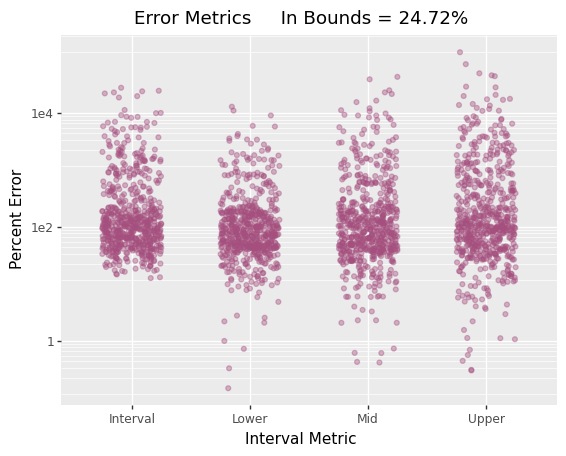

<ggplot: (99621030217)>

In [91]:
plot_interval_metrics(cqrPredictions)

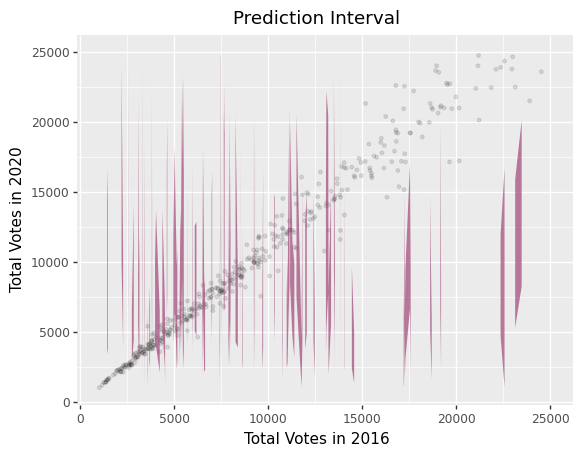

<ggplot: (99614255059)>

In [92]:
plot_interval_trends(cqrPredictions)


In [ ]:
x=Xtest.to_numpy()
y=ytest.to_numpy()
y_u= cqrPredictions['upper']
y_l= cqrPredictions['lower']
pred=pred
shade_color=cqr_color
method_name="CQR:"
title="CQR Random Forests (quantile regression)"


x_ = x[:max_show]
y_ = y[:max_show]
if y_u is not None:
    y_u_ = y_u[:max_show]
if y_l is not None:
    y_l_ = y_l[:max_show]
if pred is not None:
    pred_ = pred[:max_show]


In [ ]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

In [ ]:

fig = plt.figure()
inds = np.argsort(np.squeeze(x_))

plt.plot(x_, y_, 'k.', alpha=.2, markersize=10,
         fillstyle='none', label=u'Observations')

if (y_u is not None) and (y_l is not None):
    plt.fill(np.concatenate([x_, x_[::-1]]),
             np.concatenate([y_u_, y_l_[::-1]]),
             alpha=.3, fc=shade_color, ec='None',
             label = method_name + ' prediction interval')
    
    
if pred is not None:
    if pred_.ndim == 2:
        plt.plot(x_, pred_, 'k', lw=2, alpha=0.9,
                 label=u'Predicted low and high quantiles')
        plt.plot(x_, pred_, 'k', lw=2, alpha=0.9)
    else:
        plt.plot(x_, pred_, 'k--', lw=2, alp-ha=0.9,
                 label=u'Predicted value')
        
        
#plt.ylim([-2.5, 7])
#plt.xlabel('$X$')
#plt.ylabel('$Y$')
#plt.legend(loc='upper right')
plt.title(title)
if save_figures and (filename is not None):
    plt.savefig(filename, bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
q = .9

mod = smf.quantreg('total_votes_2020 ~ total_votes_2016', yo)
res = mod.fit(q=q)
print(res.summary())

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [ ]:
from statsmodels.regression.quantile_regression import QuantReg

ols = QuantReg(ytrain, Xtrain)
res = ols.fit(q = 0.5)
#res.predict(Xtest)

In [ ]:
res.predict(Xtest)

In [ ]:
ytest

In [ ]:
# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(ols, QuantileRegErrFunc())


# build the split CQR object
icp = IcpRegressor(nc)


# fit the conditional quantile regression to the proper training data
icp.fit(q)

# compute the absolute errors on calibration data
#icp.calibrate(Xtrain_idx_cal, ytrain_idx_cal)


In [ ]:
#OLS prediction interval 

def ols_quantile(m, X, q):
  # m: OLS statsmodels model.
  # X: X matrix.
  # q: Quantile.
  mean_pred = m.predict(X)
  se = np.sqrt(m.scale)
  return mean_pred + norm.ppf(q) * se

In [ ]:
#from statsmodels.regression.quantile_regression import QuantReg

a = np.array([1, 2, 3, 4, 5])
b = np.array([5, 6, 7, 8, 9])

qr=helper.QuantReg(endog = a, exog = b)

In [ ]:
params = dict()
params["CV"] = True
params["coverage_factor"] = 0.9
params["test_ratio"] = 0.1
params["range_vals"] = 10
params["num_vals"] = 4
params["random_state"] = random_state
quantiles = [5, 95]

In [ ]:
qr= helper.QuantReg(x,y, params = params)

In [ ]:
# define quantile random forests (QRF) parameters
params = dict()
params["CV"] = True
params["coverage_factor"] = 0.9
params["test_ratio"] = 0.1
params["range_vals"] = 5
params["num_vals"] = 8
params["random_state"] = random_state
quantiles = [5, 95]

helper.QuantileLinearRegressorAdapter(
                                      model=None,
                                      #fit_params=None,
                                      #quantiles=quantiles,
                                      params=params
                                     )

